In [1]:
# TODO - find a way to make this install the poetry enviorment
import os
os.chdir("C:\\Users\yuvmi\PycharmProjects\SequenceModelLab")
!poetry install

Installing dependencies from lock file

No dependencies to install or update


In [2]:
!pip install harold


[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np

In [4]:
import os
import glob
import pickle
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter, PillowWriter
import torch

In [5]:
import harold

In [6]:
from src.visualizations.vis_utils import animate_SSM_state_dynamics

# Analysing the best results dynamics

## Reading result logs and saving best results

In [7]:
class Result():
    
    def __init__(self, data):
        losses = np.array([l.entity for l in data["loss"]])
        l_epochs = np.array([l.epoch_logged for l in data["loss"]])
        if len(losses) == 0:
            self.min_loss = None
            return
        exploded = (np.argmax(losses) == len(losses) - 1)
        min_loss = np.min(losses)
        best_ker = data["kernel"][np.argmin(losses)-1].entity
    
        
        if np.isnan(min_loss):
            self.min_loss = None
        else:
            self.min_loss = min_loss
        self.exploded = exploded
        self.best_ker = best_ker
        self.epoch_best_res = np.argmin(losses)
        self.best_A = data["A"][np.argmin(losses)-1].entity
        self.best_B = data["B"][np.argmin(losses)-1].entity
        self.best_C = data["C"][np.argmin(losses)-1].entity
        self.train_len = len(losses)
    
    def __bool__(self):
        return self.min_loss is not None

In [8]:
experiments_results = defaultdict(dict)

In [9]:
#experiment_file_regexs = [r".\results\lag_exp\*",r".\results\lag_exp_long\*"]
experiment_file_regexs = [r".\results\lag_exp\*"]

for experiment_file_regex in experiment_file_regexs:
    for file_path in tqdm(glob.glob(experiment_file_regex)):
        if "filepart" in file_path:
            print(file_path)
            continue
        file_name = os.path.basename(file_path)
        exp_name = "_".join(file_name.split('_')[1:-1])
        exp_num = int(file_name.split('_')[-1])
        if exp_name in experiments_results and exp_num in experiments_results[exp_name]:
            continue
        with open(file_path,"rb") as f:
            data = pickle.load(f)
            result = Result(data)
            if result:
                experiments_results[exp_name][exp_num] = Result(data)
            else:
                print(exp_name,exp_num)

  0%|          | 0/358 [00:00<?, ?it/s]

fssm_ud 10


In [20]:
[k for k in experiments_results.keys()]

['diag_hippo_disc',
 'fssm_ud',
 'full_hippo_disc_bdt',
 'full_hippo_disc_sdt',
 'full_hippo_sdt',
 'rot_eq_plus',
 'rot_one_over']

In [21]:
# del experiments_results["full_hippo_bdt"][400]

## Analysis

### Analysing loss at different lags

In [22]:
def save_loss_plot(lag_nums, min_losses, exploaded, exp_name,save_path):
    plt.figure()
    plt.plot(lag_nums,min_losses)
    scatter, = plt.plot(lag_nums[exploded],min_losses[exploded],"o", color = "red")
    scatter.set_label('exploded while training')
    scatter, = plt.plot(lag_nums[~exploded],min_losses[~exploded],"o", color = "green")
    scatter.set_label('finished gracefully')
    plt.title(exp_name)
    plt.xlabel("lag")
    plt.ylabel("min train loss")
    plt.legend()
    plt.savefig(save_path)

diag_hippo_disc
fssm_ud
full_hippo_disc_bdt
full_hippo_disc_sdt
full_hippo_sdt
rot_eq_plus
rot_one_over


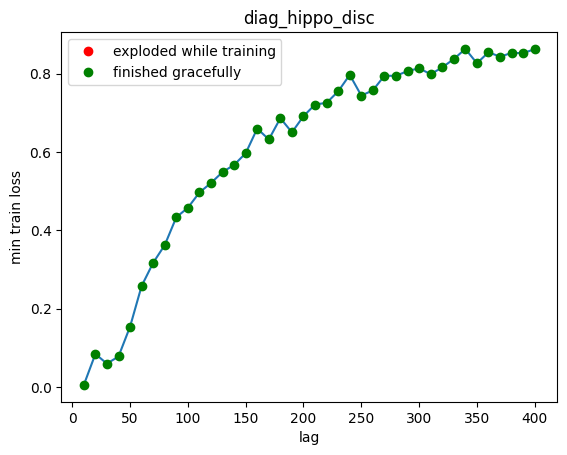

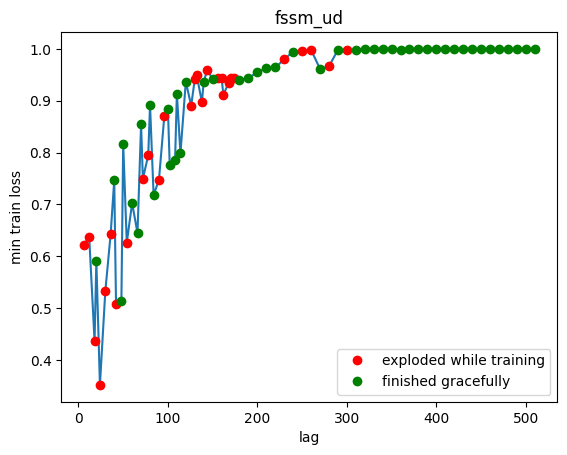

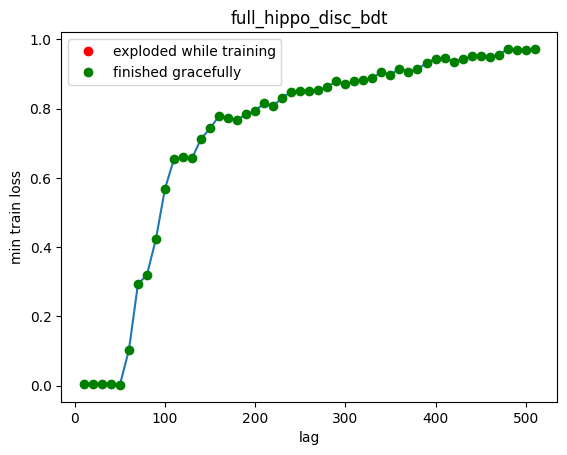

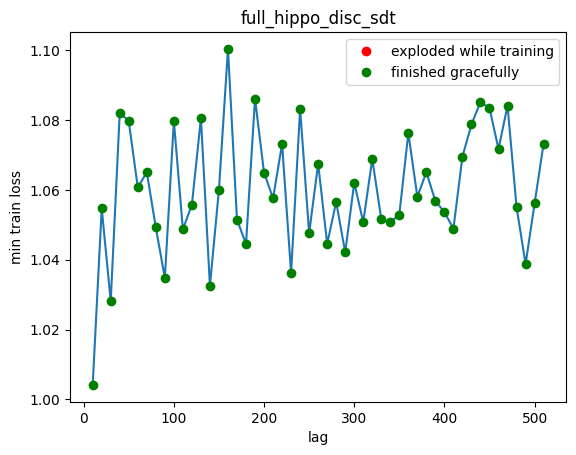

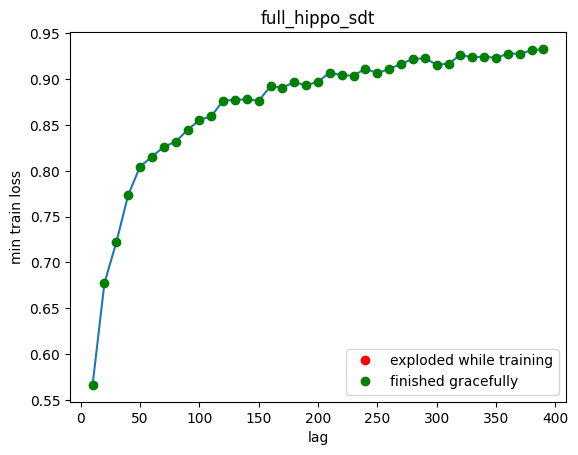

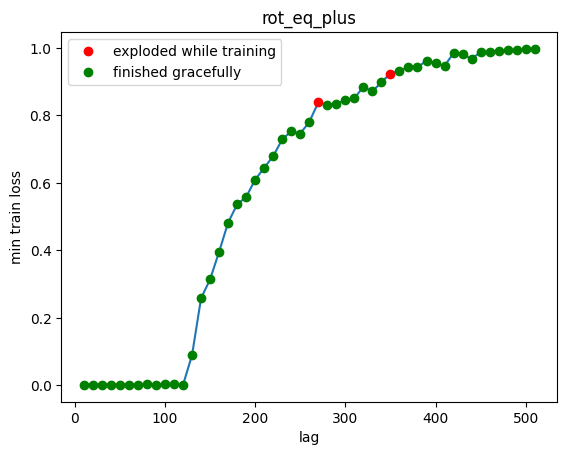

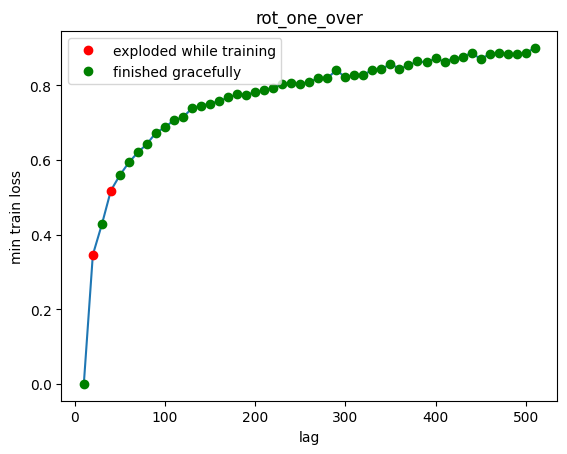

In [23]:
for exp_name in experiments_results.keys():
    print(exp_name)
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    exploded = np.array([experiments_results[exp_name][lag_num].exploded for lag_num in lag_nums])
    save_loss_plot(lag_nums, min_losses, exploded, exp_name,".\\analysis\\lags_different_ssm_model_results\\loss_plot_"+exp_name+".png")

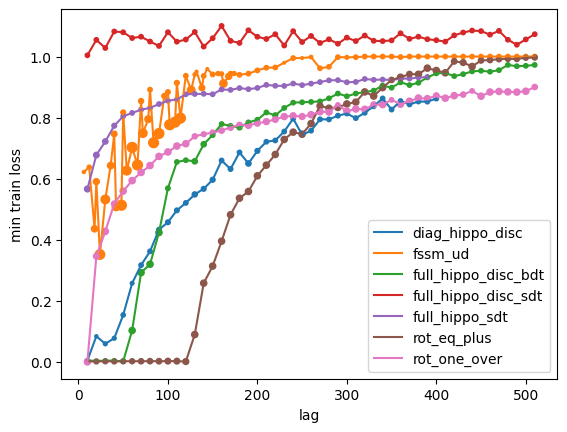

In [24]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    train_len = np.array([experiments_results[exp_name][lag_num].train_len for lag_num in lag_nums])
    plt.plot(lag_nums,min_losses,label = exp_name)
    plt.scatter(lag_nums,min_losses, s=train_len/100)
plt.xlabel("lag")
plt.ylabel("min train loss")
plt.legend()
#plt.savefig(".\\analysis\\lags_different_ssm_model_results\\all_loss_plots.png")

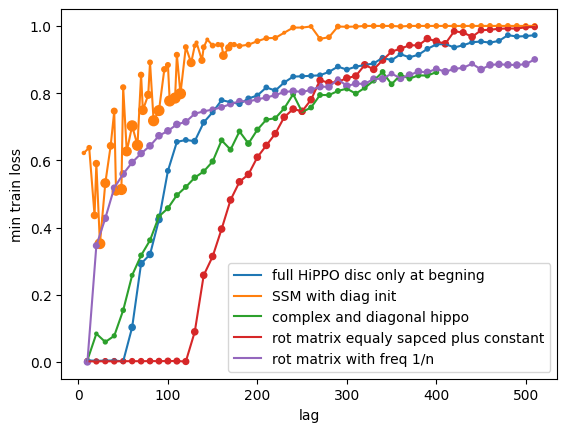

In [25]:
# Specific readable output
plt.figure()
exp_name_to_readable = {
    "full_hippo_disc_bdt":"full HiPPO disc only at begning",
    "fssm_ud":"SSM with diag init",
    "diag_hippo_disc":"complex and diagonal hippo",
    "rot_eq_plus":"rot matrix equaly sapced plus constant",
    "rot_one_over":"rot matrix with freq 1/n"
}
for exp_name in exp_name_to_readable.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    min_losses = np.array([experiments_results[exp_name][lag_num].min_loss for lag_num in lag_nums])
    train_len = np.array([experiments_results[exp_name][lag_num].train_len for lag_num in lag_nums])
    plt.plot(lag_nums,min_losses,label = exp_name_to_readable[exp_name])
    plt.scatter(lag_nums,min_losses, s=train_len/100)
plt.xlabel("lag")
plt.ylabel("min train loss")
plt.legend()

In [26]:
lag_num = 390
for exp_name in exp_name_to_readable.keys():
    min_loss = experiments_results[exp_name][lag_num].min_loss
    print(exp_name,min_loss)


full_hippo_disc_bdt 0.9317371249198914
fssm_ud 1.0000030994415283
diag_hippo_disc 0.8522323966026306
rot_eq_plus 0.9621281027793884
rot_one_over 0.8618941307067871


## Ploting the state dymaics of best results

In [27]:
# G = harold.State(a=A,b=B,c=B.transpose() ,d = [1], dt=1)
# H_cont = harold.undiscretize(G)
# H_disc = harold.discretize(H_cont,dt=1)

In [28]:
# harold._global_constants._KnownDiscretizationMethods

In [29]:
# def make_cont(A,B,C):
#     if A.ndim != 2 or A.shape[0] != A.shape[1]:
#         A = np.diag(A)
#     G = harold.State(a=A,b=B,c=C ,d = [1], dt=1)
#     H_cont = harold.undiscretize(G,"bilinear")
#     return H_cont.a, H_cont.b, H_cont.c
# def make_disc(A,B,C,dt):
#     if A.ndim != 2 or A.shape[0] != A.shape[1]:
#         A = np.diag(A)
#     G = harold.State(a=A,b=B,c=C ,d = [1],dt = None)
#     H_disc = harold.discretize(G,method="bilinear",dt=dt)
#     return H_disc.a, H_disc.b, H_disc.c

In [ ]:
# models_to_eval_dynamics = ["full_hippo_bdt","full_hippo_disc_bdt","fssm_ud"]

In [ ]:
# base_path = r".\\analysis\\state_dynamics_videos\\"
# if not os.path.exists(base_path):
#     os.makedirs(base_path)
    
# lags = [30, 60, 150, 300]
# for lag in lags:
#     for exp_name in models_to_eval_dynamics:
#         res = experiments_results[exp_name][lag]
#         path = base_path+str(exp_name)+"_"+str(lag)+".mp4"
#         A = res.best_A
#         B = res.best_B
#         C = res.best_C
#         A, B, C = make_cont(A,B,C)
#         animate_SSM_state_dynamics(A=A,B=B,C=C,save_path=path, max_time=lag+10,time_dilation=1,fps=1)
    

In [ ]:
# def disc_dynamics(A,B, dt):
#     eye = np.eye(A.shape[0])
#     left_disc_const = np.linalg.inv(eye - A / 2 * dt)
#     A = np.matmul(left_disc_const, (eye + A / 2 * dt))
#     B = np.matmul(left_disc_const, B * dt)
#     return A, B

# def plot_single_state_frame(fig,state, C, outputs, times, title):
#     axs = fig.subplots(2)
#     plt.title(title)
#     x = np.array([i for i in range(state.shape[0])])
#     C = np.copy(C)
#     contrebution = state*C
#     C /= np.max(np.abs(C))
#     C *= np.max(np.abs(state))
    
#     axs[0].scatter(x, state, color="orange")
#     #$axs[0].scatter(x, C, color="red",s=2)
#     norm_cont = contrebution/np.max(np.abs(contrebution))
#     axs[0].scatter(x[contrebution>0], C[contrebution>0], color="red",s=norm_cont[contrebution>0]*10)
#     axs[0].scatter(x[contrebution<0], C[contrebution<0], color="blue",s=norm_cont[contrebution<0]*-10)
    
#     axs[1].plot(times[:len(outputs)], outputs, color="blue")
#     axs[1].set_xlim([0,np.max(times)])
    
#     ax = plt.gca()

#     print(np.sum(contrebution[contrebution>0]),np.sum(contrebution[contrebution<0]),np.sum(contrebution[contrebution>0])+np.sum(contrebution[contrebution<0]))

# def animate_SSM_state_dynamics(A, B, C, save_path, max_time=2, time_dilation=15,
#                             fps=40):
#     dt = 1/(fps*time_dilation)
#     iterations = int(fps*time_dilation*max_time)
#     times = np.array([i*dt for i in range(iterations)])
#     #A, B = disc_dynamics(A, B, dt)
#     A,B,C =make_disc(A,B,C,dt)
                     
#     writer = FFMpegWriter(fps=fps)
#     fig = plt.figure()

#     x = B
#     outputs = []
#     with writer.saving(fig, save_path, 100):
#         for i in tqdm(range(iterations)):
#             fig.clear()
#             y = np.matmul(C, x)[0,0]
#             outputs.append(y)
#             title = "time={:.2f},dt={}".format(dt*(i+1),dt)
#             plot_single_state_frame(fig,x[:,0],C[0,:],outputs, times, title)
#             writer.grab_frame()
            
#             x = np.matmul(A, x)
#     print(np.max(outputs))

### Creating kernel videos

In [30]:
def plot_single_kernel_frame(kernel, lag):
    plt.title("lag=%d"%lag)
    plt.plot(lag,kernel[lag],"o",color = "red")
    plt.plot(kernel)
    ax = plt.gca()
    ax.set_ylim([0, max(np.max(kernel),0.7)])

In [31]:

def make_videos_from_list_of_arrays(arrays, lags, save_path):
    writer = FFMpegWriter(fps=3)
    img = [] # some array of images
    frames = [] # for storing the generated images
    fig = plt.figure()
    with writer.saving(fig, save_path, 100):
        for i in tqdm(range(len(arrays))):
            fig.clear()
            plot_single_kernel_frame(arrays[i], lags[i])
            writer.grab_frame()



  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

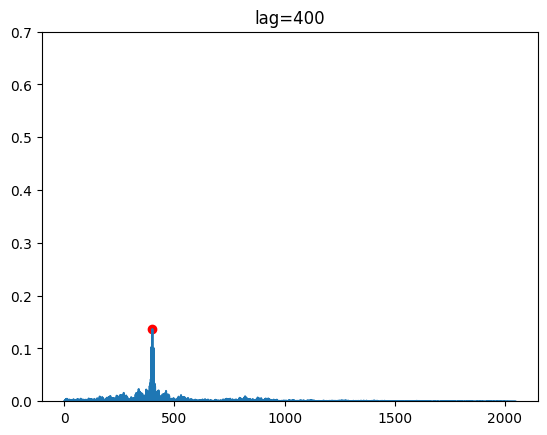

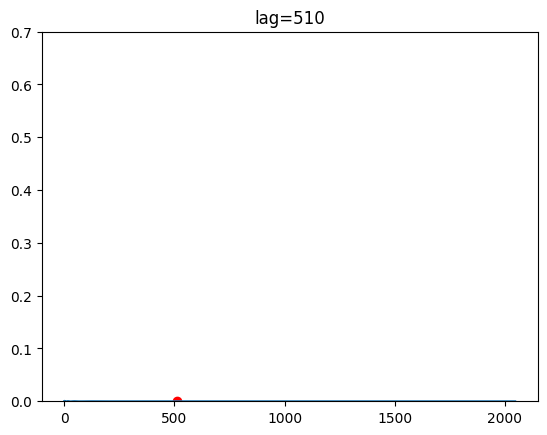

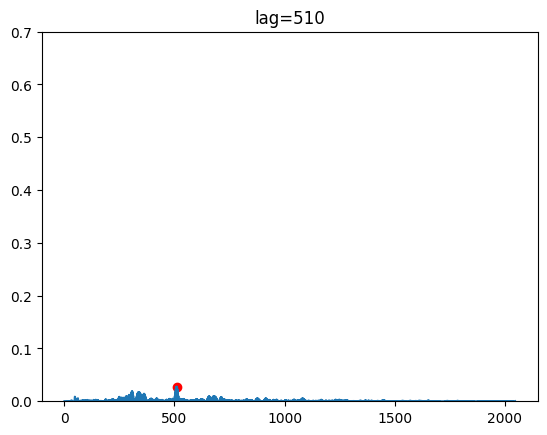

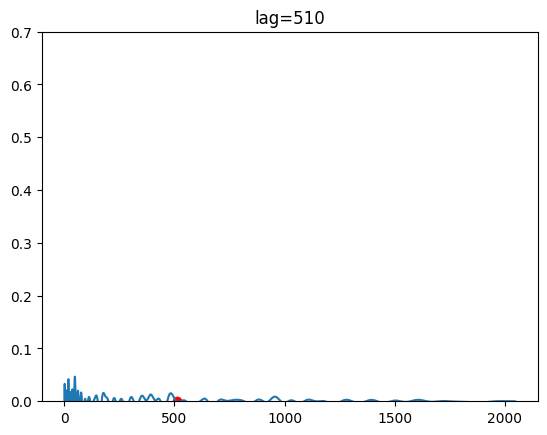

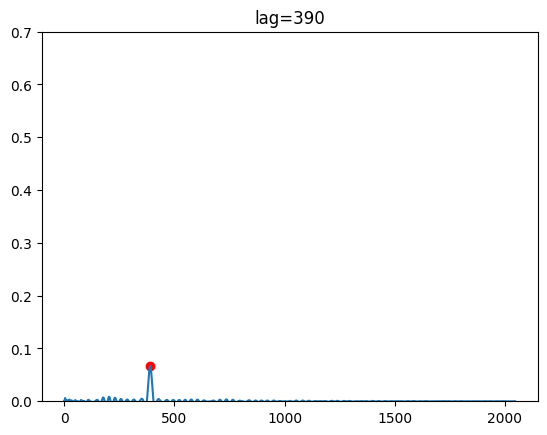

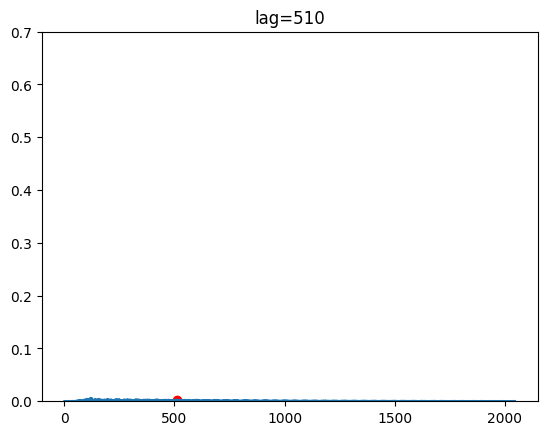

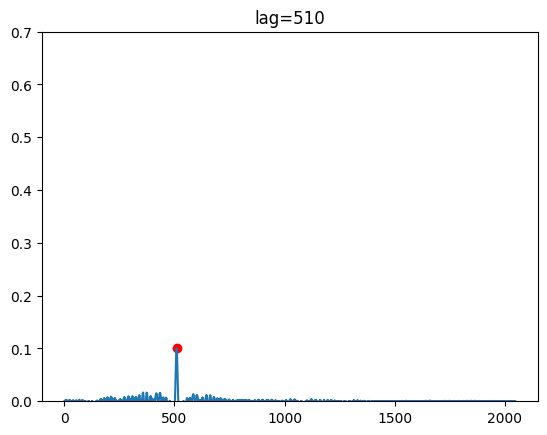

In [32]:
for exp_name in tqdm(experiments_results.keys()):
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    ordered_kernels = np.array([experiments_results[exp_name][lag_num].best_ker for lag_num in lag_nums])
    make_videos_from_list_of_arrays(ordered_kernels, lag_nums,".\\analysis\\lags_different_ssm_model_results\\kernel_vid_"+exp_name+".mp4")

## End state

In [11]:
def get_sorted_eigen(matrix):
    if matrix.ndim == 1:
        e = matrix
    else:
        e = np.linalg.eig(matrix)[0]
    e = np.abs(e)
    return np.sort(e)

In [12]:
def get_sorted_eigen_complex(matrix):
    if matrix.ndim == 1:
        e = matrix
    else:
        e = np.linalg.eig(matrix)[0]
    e = e[np.argsort(np.abs(e))]
    return e

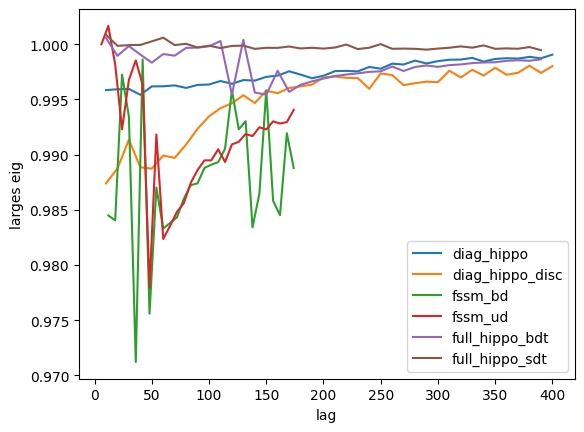

In [192]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
    highes_e = [get_sorted_eigen(A)[-1] for A in best_As]
    plt.plot(lag_nums,highes_e,label = exp_name)
plt.xlabel("lag")
plt.ylabel("larges eig")
plt.legend()
plt.savefig(".\\analysis\\lags_different_ssm_model_results\\eig_dyn.png")

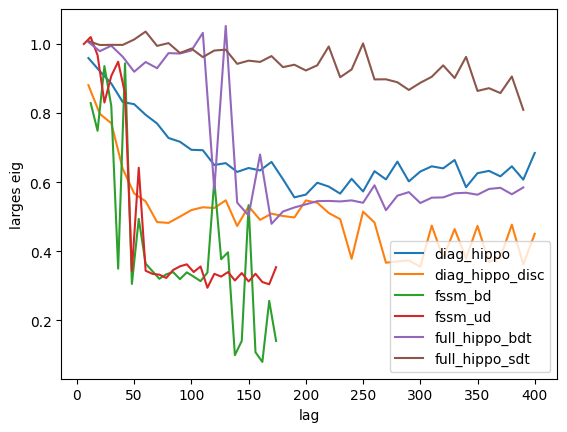

In [193]:
plt.figure()
for exp_name in experiments_results.keys():
    lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
    lag_nums.sort()
    best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
    highes_e = [get_sorted_eigen(A)[-1] for A in best_As]
    plt.plot(lag_nums,highes_e**lag_nums,label = exp_name)
plt.xlabel("lag")
plt.ylabel("larges eig")
plt.legend()
plt.savefig(".\\analysis\\lags_different_ssm_model_results\\eig_dyn_relative.png")

In [137]:
# plt.figure()
# for exp_name in experiments_results.keys():
#     lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
#     lag_nums.sort()
#     best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
#     highes_e = [get_sorted_eigen_complex(A)[-1].imag for A in best_As]
#     plt.plot(lag_nums,highes_e,label = exp_name)
# plt.xlabel("lag")
# plt.ylabel("larges eig")
# plt.legend()

In [138]:
# plt.figure()
# for exp_name in experiments_results.keys():
#     lag_nums = np.array([lag_num for lag_num in experiments_results[exp_name].keys()])
#     lag_nums.sort()
#     best_As = np.array([experiments_results[exp_name][lag_num].best_A for lag_num in lag_nums])
#     highes_e = [get_sorted_eigen_complex(A)[-1].real for A in best_As]
#     plt.plot(lag_nums,highes_e,label = exp_name)
# plt.xlabel("lag")
# plt.ylabel("larges eig")
# plt.legend()

## Ploting dynamics

In [33]:
class FullResult():
    
    def __init__(self, data):
        losses = np.array([l.entity for l in data["loss"]])
        l_epochs = np.array([l.epoch_logged for l in data["loss"]])
        if len(losses) == 0:
            self.min_loss = None
            return
        exploded = (np.argmax(losses) == len(losses) - 1)
        min_loss = np.min(losses)
        best_ker = data["kernel"][np.argmin(losses)-1].entity
        
        
        
        if np.isnan(min_loss):
            self.min_loss = None
        else:
            self.min_loss = min_loss
            
        self.exploded = exploded
        self.best_ker = best_ker
        self.epoch_best_res = np.argmin(losses)
        self.As = [l.entity for l in data["A"]]
        self.Bs = [l.entity for l in data["B"]]
        self.Cs = [l.entity for l in data["C"]]
        self.kernels = [l.entity for l in data["kernel"]]
        self.epochs = np.array([l.epoch_logged for l in data["loss"]])
        self.losses = losses
    
    def __bool__(self):
        return self.min_loss is not None

def get_sorted_eigen(matrix):
    if matrix.ndim == 1:
        e = matrix
    else:
        e = np.linalg.eig(matrix)[0]
    e = np.abs(e)
    return np.sort(e)

def get_result_from_file_path(file_path): 
    with open(file_path,"rb") as f:
        data = pickle.load(f)
        result = FullResult(data)
        if result:
            return result
        else:
            return "None"

def get_f_result(exp_name, exp_num):
    filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name=exp_name,
                                                                       exp_num=exp_num)
    return get_result_from_file_path(filepath)

def draw_dynamics(exp_name, exp_num):
    filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name=exp_name,
                                                                       exp_num=exp_num)
    print(filepath)
    r = get_result_from_file_path(filepath)
    
    eig = []
    for A in tqdm(r.As):
        eig.append(get_sorted_eigen(A))
    eig = np.array(eig)
    Cs = np.abs(np.array(r.Cs)[:,0,:])
    print(np.array(r.Cs).shape)

    plt.figure()
    plt.plot(r.epochs,eig[:,:5])
    plt.figure()
    plt.plot(r.epochs,eig[:,-5:])
    
    plt.figure()
    plt.plot(r.epochs,Cs)
    

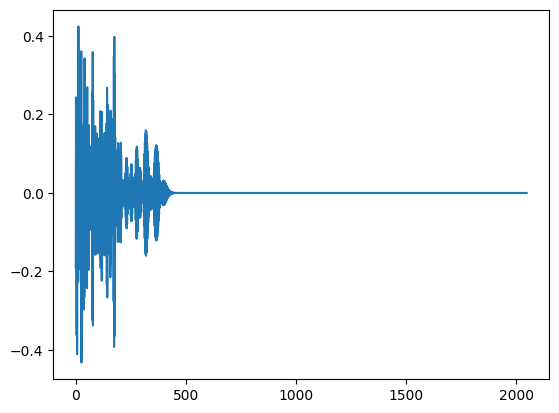

C:\Users\yuvmi\AppData\Local\pypoetry\Cache\virtualenvs\sequencemodellab-8OMl2XFc-py3.8\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


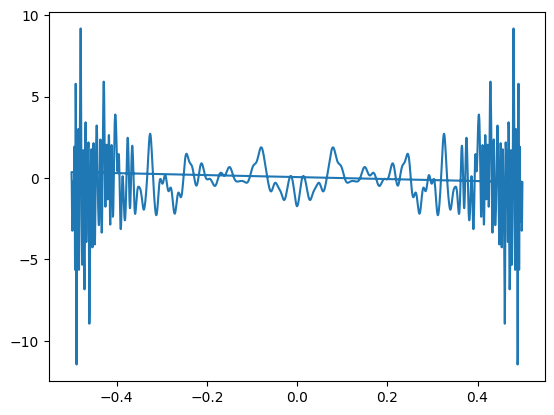

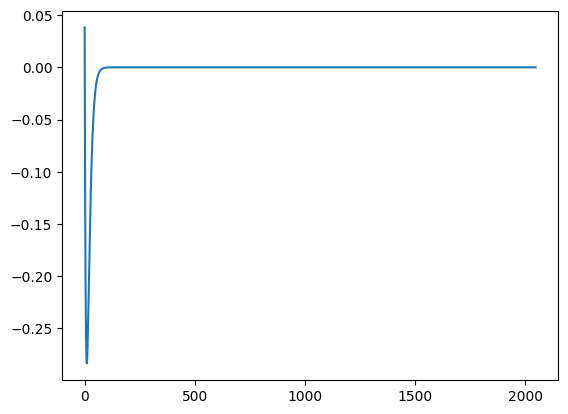

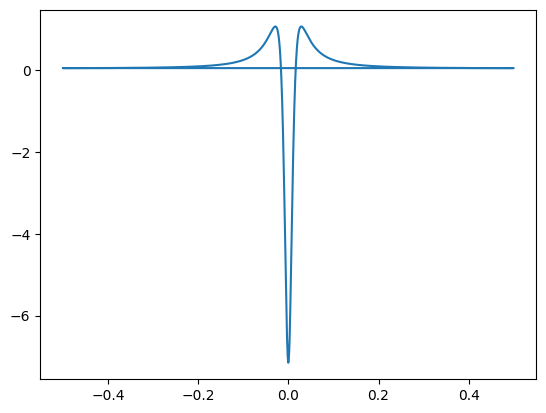

In [25]:
r = get_f_result("full_hippo_bdt",120)
xf = np.fft.fftfreq(len(r.kernels[0]))
plt.figure()
plt.plot(r.kernels[0])
plt.show()

plt.figure()
plt.plot(xf,np.fft.fft(r.kernels[0]))
plt.show()


r = get_f_result("fssm_bd",120)
plt.figure()
plt.plot(r.kernels[0])
plt.show()


plt.figure()
plt.plot(xf,np.fft.fft(r.kernels[0]))
plt.show()




In [63]:
filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name="full_hippo_bdt",
                                                                       exp_num=120)
print(filepath)
r = get_result_from_file_path(filepath)

.\results\lag_exp\fast_full_hippo_bdt_120


In [115]:
[e for e in experiments_results.keys()]

['diag_hippo',
 'diag_hippo_disc',
 'fssm_bd',
 'fssm_ud',
 'full_hippo_bdt',
 'full_hippo_sdt']

.\results\lag_exp\fast_full_hippo_bdt_120


  0%|          | 0/1366 [00:00<?, ?it/s]

(1366, 1, 128)


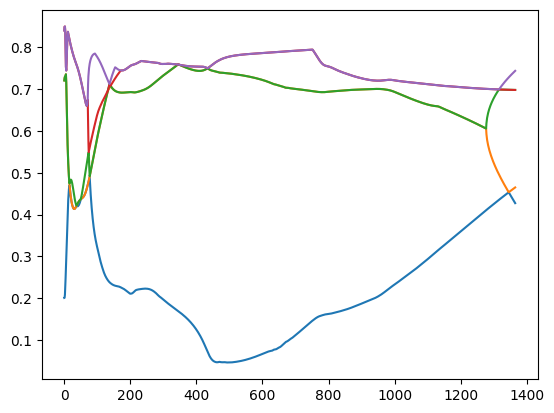

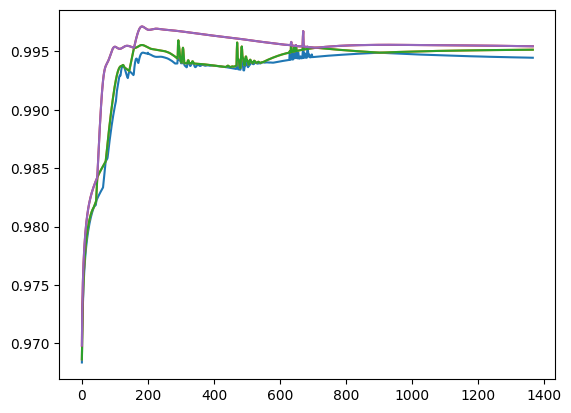

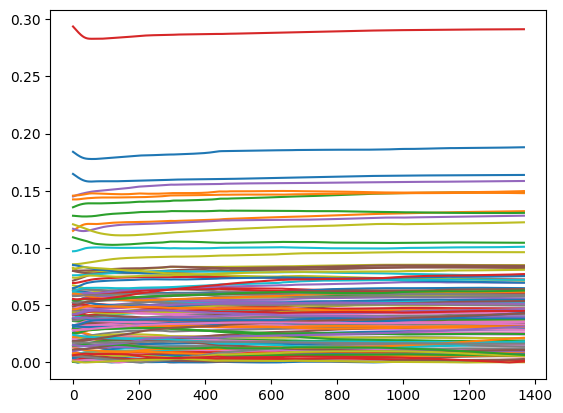

In [116]:
draw_dynamics("full_hippo_bdt",120)

.\results\lag_exp\fast_fssm_ud_120


  0%|          | 0/1895 [00:00<?, ?it/s]

(1895, 1, 128)


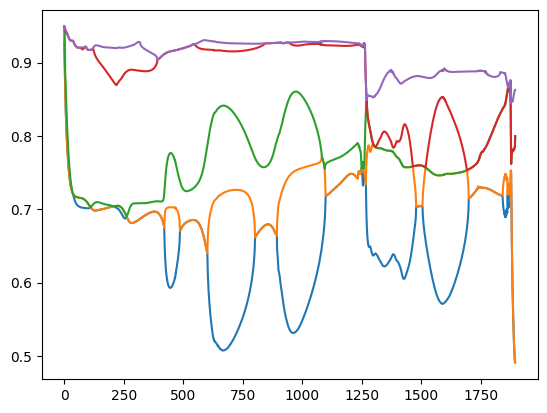

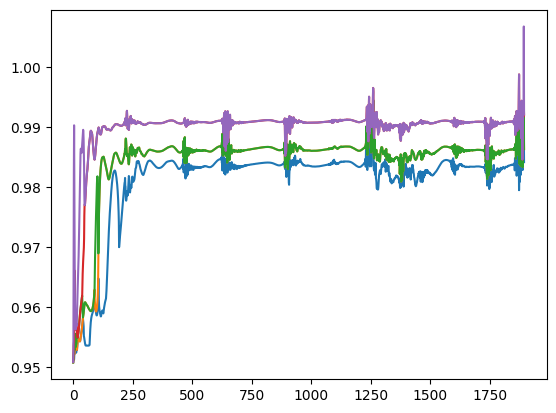

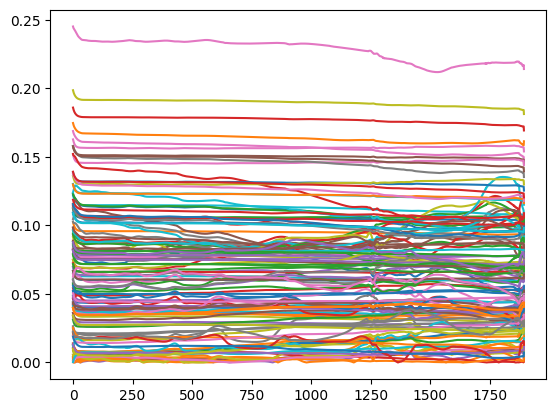

In [117]:
draw_dynamics("fssm_ud",120)

In [ ]:
draw_dynamics("full_hippo_bdt",180)

In [119]:
draw_dynamics("fssm_ud",180)

.\results\lag_exp\fast_fssm_ud_200


FileNotFoundError: [Errno 2] No such file or directory: '.\\results\\lag_exp\\fast_fssm_ud_200'

## Controlabilty

In [54]:
def get_full_obs_eigenvalues(A, C):
    n = A.shape[0]
    controlabilty_matrix = np.zeros((n, n))
    observabilty_matrix = np.zeros((n, n))
    #controlabilty_matrix_row_norm = np.zeros(n)
    
    for i in range(n):
        a_pow_i = np.linalg.matrix_power(A, i)
        #a_pow_i_times_b = a_pow_i.dot(B.transpose())
        c_times_a_pow_i = C.dot(a_pow_i)
        #controlabilty_matrix[:, i] = a_pow_i_times_b.reshape(-1)
        observabilty_matrix[i,:] = c_times_a_pow_i.reshape(-1)
        #controlabilty_matrix_row_norm[i] = np.linalg.norm(a_pow_i_times_b)
        # print(hankel_matrix)
    #u, s, vh = np.linalg.svd(controlabilty_matrix)
    #parcital_s = C.dot(u)

    #parcital_s = s*s
    #self.controlabilty_eigenval_arr.append(parcital_s)

    u, s, vh = np.linalg.svd(observabilty_matrix)
    parcital_s = s * s
    #self.observabilty_eigenval_arr.append(parcital_s)
    #self.controlabilty_row_norm.append(controlabilty_matrix_row_norm)
    return np.sort(np.abs(parcital_s))

In [64]:
def get_diag_obs_eigenvalues(A, C):
    n = A.shape[0]
    controlabilty_matrix = np.zeros((n, n))
    observabilty_matrix = np.zeros((n, n))
    #controlabilty_matrix_row_norm = np.zeros(n)
    
    for i in range(n):
        a_pow_i = A**i
        #a_pow_i_times_b = a_pow_i.dot(B.transpose())
        c_times_a_pow_i = C * a_pow_i
        observabilty_matrix[i,:] = c_times_a_pow_i.reshape(-1)
        #controlabilty_matrix_row_norm[i] = np.linalg.norm(a_pow_i_times_b)
        # print(hankel_matrix)
    #u, s, vh = np.linalg.svd(controlabilty_matrix)
    #parcital_s = C.dot(u)

    #parcital_s = s*s
    #self.controlabilty_eigenval_arr.append(parcital_s)

    u, s, vh = np.linalg.svd(observabilty_matrix)
    parcital_s = s * s
    #self.observabilty_eigenval_arr.append(parcital_s)
    #self.controlabilty_row_norm.append(controlabilty_matrix_row_norm)
    return np.sort(np.abs(parcital_s))

In [65]:
def get_obs_eigenvalues(A,C):
    if A.ndim == 2:
        return get_full_obs_eigenvalues(A,C)
    else:
        return get_diag_obs_eigenvalues(A,C)

In [92]:
def draw_controlabilty_dynamics(exp_name, exp_num):
    filepath = '.\\results\\lag_exp\\fast_{exp_name}_{exp_num}'.format(exp_name=exp_name,
                                                                       exp_num=exp_num)
    r = get_result_from_file_path(filepath)
    
    obs = []
    for i in tqdm(range(len(r.As))):
        obs.append(get_obs_eigenvalues(r.As[i],r.Cs[i]))
        #if (i % 100) == 99:
        #    plt.figure()
        #    plt.plot(r.epochs[:len(obs)],np.array(obs))
        #    plt.show()
    obs = np.array(obs)
    plt.figure()
    plt.plot(r.epochs,obs)

    

  0%|          | 0/1366 [00:00<?, ?it/s]

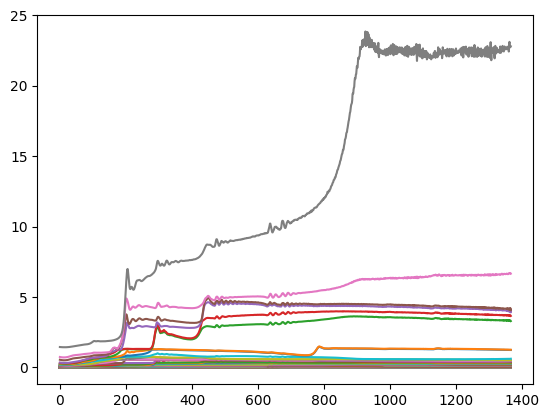

In [95]:
draw_controlabilty_dynamics("full_hippo_bdt",120)

  0%|          | 0/1895 [00:00<?, ?it/s]

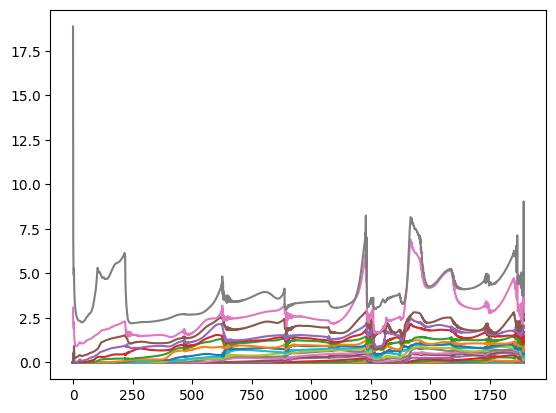

In [118]:
draw_controlabilty_dynamics("fssm_ud",120)

In [38]:
import torch
from src.models.strategies.calc import RecurrentSMMCalcStrategy
device = torch.device('cpu')
def get_ker(A,B,C,ker_len = 1000):
    x = np.zeros([1, ker_len, 1])
    x[0, 0, 0] = 1
    ker = RecurrentSMMCalcStrategy().calc(torch.Tensor(x),
                                          torch.Tensor(A),
                                          torch.Tensor(B),
                                          torch.Tensor(C),
                                          torch.Tensor(np.array([0])),
                                          device)
    return ker[0, :, 0]

In [39]:
r = get_f_result("full_hippo_bdt",180)

FileNotFoundError: [Errno 2] No such file or directory: '.\\results\\lag_exp\\fast_full_hippo_bdt_180'

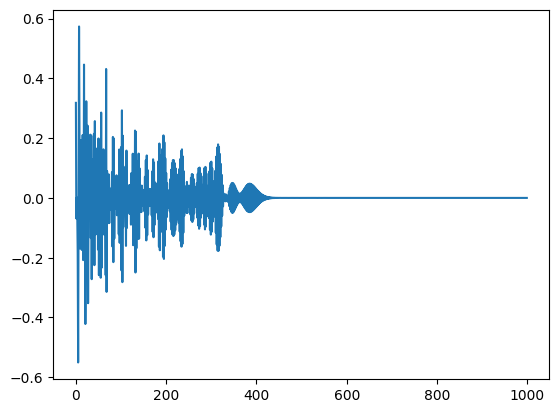

In [149]:
A = r.As[0]
B = r.Bs[0]
C = r.Cs[0]
plt.plot(get_ker(A,B,C))

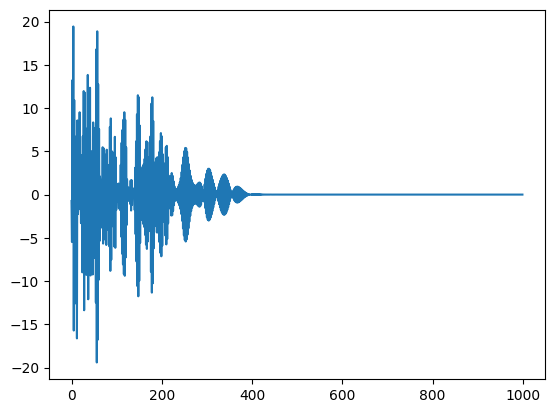

In [146]:
A = r.As[0]
B = torch.randn([n,1])
C = torch.randn([1,n])
plt.plot(get_ker(A,B,C))

In [109]:
def get_diag_i(i,n):
    return 1*((n-(i+1))**2/(n**2)) + 0.5*(1-(n-(i+1))**2/(n**2))

def get_under_diag_i(i,n):
    return -1 * (1-get_diag_i(i, n))

In [139]:
A = np.copy(r.As[0])
# n = A.shape[0]
# for i in range(n):
#     for j in range(n):
#         if np.abs(i-j)>90:
#             A[i,j] = 0


# # A = np.zeros([128,128])
# # A = torch.zeros([n,n])
# # for i in range(n):
# #     A[i,i] = get_diag_i(i,n)
# # for i in range(n-1):
# #     A[i+1,i] = get_under_diag_i(i,n)

# def A_lagT_innit_func(N):
#     A = np.eye(N)  - np.tril(np.ones((N, N))) / 2
#     A = torch.Tensor(A)
#     return A

# def B_lagT_init_func(N):
#     B = np.ones((N, 1))
#     B = torch.Tensor(B)
#     return B
# A = A_lagT_innit_func(128)
# B = B_lagT_init_func(128)

In [161]:
A = np.zeros(r.As[0].shape)
n = A.shape[0]
v = 0.70
for i in range(n):
    for j in range(i):
        A[i,j] = -1*(v**(i-j+1))
for i in range(n):
    A[i,i] = v

In [167]:
A = torch.Tensor(A) + torch.randn(A.shape) * 0.0001

In [168]:
A[0,0],A[1,1],A[1,0]

(tensor(0.7012), tensor(0.6994), tensor(-0.4909))

In [35]:
n=128
A = np.zeros([n,n])
n = A.shape[0]

# def g(i):
#     return (n-i)/n

# # for i in range(n-1):
# #     A[i+1,i] = -1*(1-g(i+1))/2
# # for i in range(n-2):
# #     A[i+2,i] = (1-g(i+2))/4
# # for i in range(n):
# #     A[i,i] = g(i)
for i in range(n):
    A[i,i] = 10000
for i in range(n-1):
    A[i+1,i] = 1

In [36]:
# u =  np.zeros([n,1])
# u[0,0] = 1
# u = torch.Tensor(u)
# U = [torch.clone(u)+torch.randn([n,1])*0.01 for i in range(n)]
# U = torch.concat(U,axis = 1)
# U_inv = U.inverse()
# A = torch.diag(torch.Tensor([i/n for i in range(n)]))

# A = U.mm(A).mm(U_inv)

In [103]:
A =  torch.zeros([n,n])

eps = 0.005
def get_real_i(i):
    return i/n

def get_imag_i(i):
    return np.sqrt((1-eps)**2-get_real_i(i)**2)

def get_rot_i(i):
    rot =  torch.zeros([2,2])
    rot[0,0] = get_real_i(i)
    rot[1,1] = get_real_i(i)
    rot[0,1] = -1*get_imag_i(i)
    rot[1,0] = get_imag_i(i)
    return rot
    
for i in range(0,n,2):
    A[i:i+2,i:i+2] = get_rot_i(i)

In [25]:
def polar_to_complex(radii, angles_radians):
    return radii * np.exp(1j*angles_radians)

In [208]:
num_hidden_state = 2*64

radii = 0.995
eff_hidden = num_hidden_state//2

# def get_i_eigen(i):
#     print(polar_to_complex(radii, i*np.pi/(eff_hidden-1)),i*np.pi/(eff_hidden-1),i)
#     return polar_to_complex(radii, i*np.pi/(eff_hidden-1))



# def get_i_eigen(i):
#     #return polar_to_complex(radii, np.pi/2*(1-(1/(i+1))**0.5))
#     angle = np.pi*(i/(eff_hidden-1))
#     angle += 2**0.5
#     angle = angle%np.pi
#     return polar_to_complex(radii, angle)
    
    
def get_i_eigen(i):
    #return polar_to_complex(radii, np.pi/2*(1-(1/(i+1))**0.5))
    angle = 2*np.pi*(1/(i+1))
    return polar_to_complex(radii, angle)

def get_real_i(i):
    return get_i_eigen(i).real

def get_imag_i(i):
    return get_i_eigen(i).imag

def get_rot_i(i):
    rot = torch.zeros([2, 2])
    # this matrix has eigenvalue get_real_i(i) +- i*get_imag_i(i)
    rot[0, 0] = get_real_i(i)
    rot[1, 1] = get_real_i(i)
    rot[0, 1] = -1 * get_imag_i(i)
    rot[1, 0] = get_imag_i(i)
    return rot

def get_A(n):
    A = torch.zeros([n, n])
    for i in range(0, n, 2):
        A[i:i + 2, i:i + 2] = get_rot_i(i//2)
    return A

n=num_hidden_state
A = get_A(n)

In [209]:
A_tmp = torch.Tensor(A)
np.sort(np.abs(np.linalg.eig(A_tmp)[0])[-10:])

array([0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995,
       0.995], dtype=float32)

In [210]:
# #A = r.As[0]
A_tmp = torch.Tensor(A) + torch.randn(A.shape) * 0.000000001
np.sort(np.abs(np.linalg.eig(A_tmp)[0])[-10:])

array([0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995,
       0.995], dtype=float32)

In [211]:
np.linalg.cond(A)

1.0000001

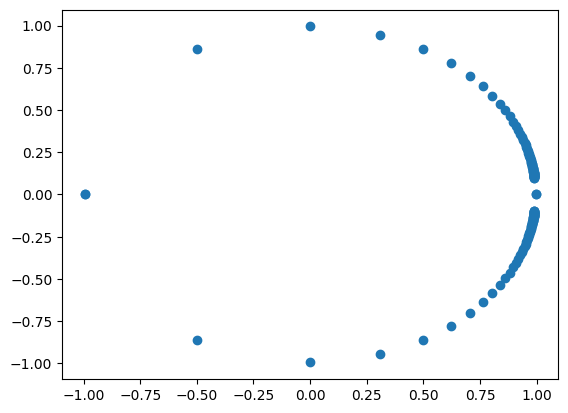

In [212]:
x = np.sort(np.linalg.eig(A)[0])
plt.figure()
plt.scatter(x.real,x.imag)

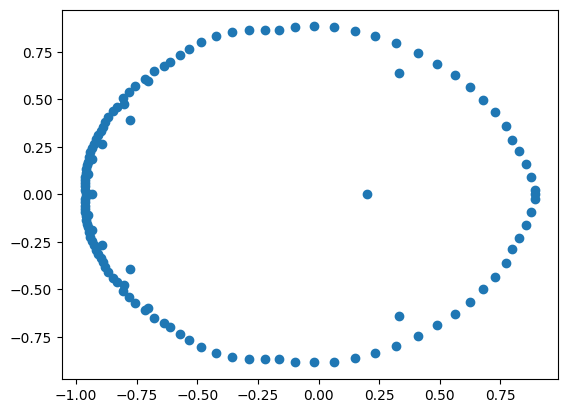

In [141]:
x = np.sort(np.linalg.eig(A)[0])
plt.figure()
plt.scatter(x.real,x.imag)

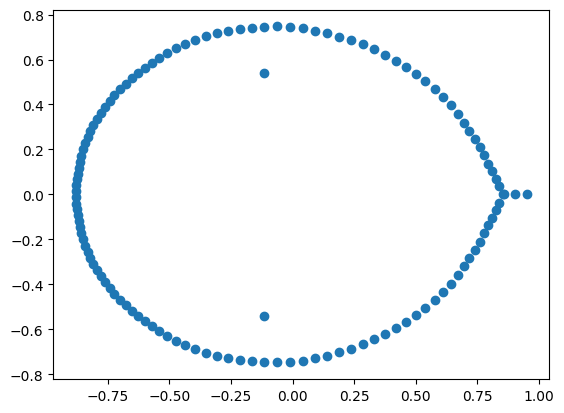

In [180]:
x = np.sort(np.linalg.eig(torch.Tensor(Hippo)+torch.randn(A.shape) * 0.000000000001)[0])
plt.figure()
plt.scatter(x.real,x.imag)

In [216]:
def get_rot_ssm_equally_spaced(num_hidden_state, device):

    eps = 0.005

    # def get_real_i(i):
    #     return i / num_hidden_state * (1 - eps)
    #
    # def get_imag_i(i):
    #     return np.sqrt((1 - eps) ** 2 - get_real_i(i) ** 2)

    radii = 1#0.995
    eff_hidden = num_hidden_state//2

    def get_i_eigen(i):
        print(polar_to_complex(radii, i * np.pi / (eff_hidden - 1)), i * np.pi / (eff_hidden - 1), i)
        return polar_to_complex(radii, i * np.pi / (eff_hidden - 1))

    def get_real_i(i):
        return get_i_eigen(i).real

    def get_imag_i(i):
        return get_i_eigen(i).imag

    def get_rot_i(i):
        rot = torch.zeros([2, 2])
        # this matrix has eigenvalue get_real_i(i) +- i*get_imag_i(i)
        rot[0, 0] = get_real_i(i)
        rot[1, 1] = get_real_i(i)
        rot[0, 1] = -1 * get_imag_i(i)
        rot[1, 0] = get_imag_i(i)
        return rot

    def get_A(n):
        A = torch.zeros([n, n])
        for i in range(0, n, 2):
            A[i:i + 2, i:i + 2] = get_rot_i(i // 2)
        return A

    return SMMModel(
        num_hidden_state=num_hidden_state,
        input_dim=1,
        output_dim=1,
        ssm_param_strategy=param_strat.DiscreteSMMParametrizationStrategy(
            ssm_init_strategy=init_strat.FlexibleSSMInitStrategy(
                A_init_func=get_A,
                B_init_func=lambda n: 0.2*torch.randn([n, 1], dtype=torch.float),
                C_init_func=lambda n: 0.2*torch.randn([1, n], dtype=torch.float),
                D_init_func=lambda n: torch.zeros([1, 1], dtype=torch.float),
            ),
            ssm_storing_strategy=storing_strat.RealArrayStoringStrategy(),
        ),
        ssm_calc_strategy=calc_strat.RecurrentSMMCalcStrategy(),
        trainable_param_list=["C", "B"],
        device=device
    ),)

SyntaxError: unmatched ')' (38431702.py, line 55)

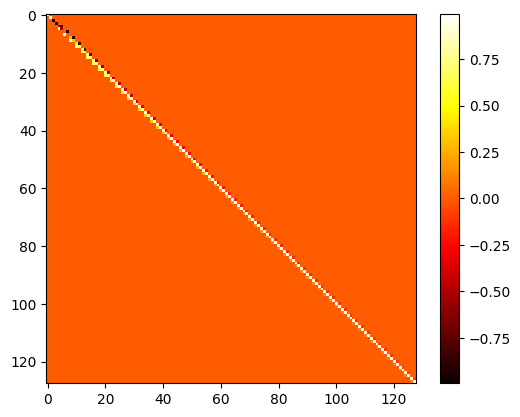

In [217]:
plt.imshow(A, cmap='hot', interpolation='nearest')
plt.colorbar();
plt.show()

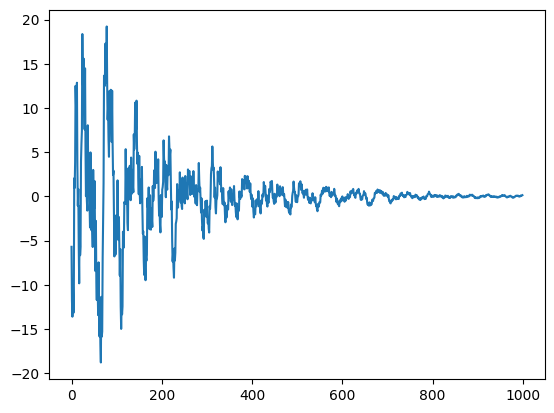

In [218]:
#A = np.copy(r.As[0])
# n = A.shape[0]
#for i in range(n):
#    for j in range(n):
#        if np.abs(i-j)>2:
#            A[i,j] = 0
B = torch.randn([n,1])
C = torch.randn([1,n])
k = get_ker(A,B,C)
plt.plot(k)

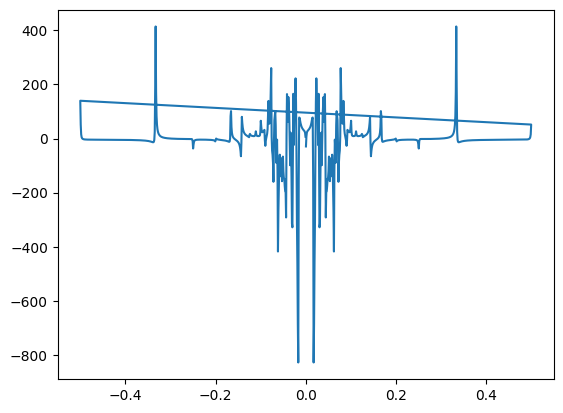

In [219]:
r = get_f_result("full_hippo_bdt",120)
xf = np.fft.fftfreq(len(k))

plt.figure()
plt.plot(xf,np.fft.fft(k))
plt.show()

In [76]:
np.abs(i-j)>200

False

In [177]:
def A_hippo_init_func(N):
    q = np.arange(N, dtype=np.float64)
    col, row = np.meshgrid(q, q)
    r = 2 * q + 1
    M = -(np.where(row >= col, r, 0) - np.diag(q))
    T = np.sqrt(np.diag(2 * q + 1))
    A = T @ M @ np.linalg.inv(T)

    return A


def B_hippo_init_func(N):
    q = np.arange(N, dtype=np.float64)
    col, row = np.meshgrid(q, q)
    r = 2 * q + 1
    M = -(np.where(row >= col, r, 0) - np.diag(q))
    T = np.sqrt(np.diag(2 * q + 1))
    A = T @ M @ np.linalg.inv(T)
    B = np.diag(T)[:, None]
    B = B.copy()
    return B

def disc_dynamics(A,B, dt):
    eye = np.eye(A.shape[0])
    left_disc_const = np.linalg.inv(eye - A / 2 * dt)
    A = np.matmul(left_disc_const, (eye + A / 2 * dt))
    B = np.matmul(left_disc_const, B * dt)
    return A, B

A = A_hippo_init_func(128)
B = B_hippo_init_func(128)
A, B = disc_dynamics(A, B, 0.05)
Hippo = A

In [30]:
r1 = get_f_result("rot_eq_plus",150)
r2 = get_f_result("fssm_ud",150)
r3 = get_f_result("rot_one_over",150)

In [26]:
r1.As[0].shape,r2.As[0].shape

((128, 128), (128, 128))

In [28]:
r1.kernels[0].shape,r1.kernels[1].shape

((2048,), (2048,))

In [31]:
r1.epoch[0].shape,r1.kernels[1].shapeb

AttributeError: 'FullResult' object has no attribute 'epoch'